Paper link
https://link.springer.com/content/pdf/10.1007/s00521-025-11101-z.pdf

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import wandb

In [ ]:
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: faizarashid1111 (faizarashid1111-comsats-university-islamabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Getting Rumor/Non-rumor .json from .tar

In [ ]:
import tarfile
import json
import pandas as pd
from tqdm import tqdm
import os

TAR_PATH = "/content/drive/MyDrive/Datasets/PHEME_veracity.tar"

data = []

# Open and filter only clean .json files (skip "._" files)
with tarfile.open(TAR_PATH, 'r') as tar:
    members = [
        m for m in tar.getmembers()
        if 'source-tweet' in m.name
        and m.name.endswith('.json')
        and not os.path.basename(m.name).startswith('._')
    ]

    for member in tqdm(members, desc="Reading JSONs from tar"):
        try:
            f = tar.extractfile(member)
            if f is None:
                continue
            tweet = json.load(f)
            text = tweet.get('text', '').replace('\n', ' ').strip()

            # Determine event + label
            parts = member.name.split('/')
            if len(parts) < 4:
                continue
            event = parts[1]
            label_folder = parts[2]
            label = 1 if label_folder == 'rumours' else 0

            if text:
                data.append({
                    'event': event,
                    'text': text,
                    'label': label
                })
        except Exception as e:
            print(f"Error with {member.name}: {e}")

df = pd.DataFrame(data)
df.to_csv('/content/pheme_rnr_from_tar.csv', index=False)
print("CSV created with shape:", df.shape)


Reading JSONs from tar: 100%|██████████| 6425/6425 [00:00<00:00, 18456.77it/s]

CSV created with shape: (6425, 3)


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords (only once)
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercasing
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stop words
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("/content/pheme_rnr_from_tar.csv")
df = df[['text', 'label']]

df.dropna(subset=['label'], inplace=True)

df['label'] = df['label'].astype(int)

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)


In [ ]:
df['text'] = df['text'].apply(clean_text)

ON BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=128)


# Pytorch

Custom PyTorch Dataset class (PhemeDataset) to wrap the tokenized inputs and corresponding labels for training and evaluation.

In [ ]:
class PhemeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        # It Ensure labels are int and in correct shape
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} #extract one item from tokenizer output
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


# Bert Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir="./logs",
    report_to="wandb",
    run_name="bert-pheme-rnr"
)


In [ ]:
train_dataset = PhemeDataset(train_encodings, train_labels)
val_dataset = PhemeDataset(val_encodings, val_labels)

trainer = Trainer(
    model=model,
    args=training_args,
    # These datasets are now defined and contain torch.long labels
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)

trainer.train()

<ipython-input-23-1279439214>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.404097
2,0.484300,0.350864
3,0.484300,0.401631


TrainOutput(global_step=966, training_loss=0.37801718070146706, metrics={'train_runtime': 382.0694, 'train_samples_per_second': 40.359, 'train_steps_per_second': 2.528, 'total_flos': 1014293118412800.0, 'train_loss': 0.37801718070146706, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}


In [ ]:
trainer = Trainer(
    model=model,  # already trained model
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)


<ipython-input-26-1482750081>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
metrics = trainer.evaluate()

# Print each metric on a new line
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


eval_loss: 0.4016
eval_model_preparation_time: 0.0050
eval_accuracy: 0.8529
eval_f1: 0.7830
eval_runtime: 8.5884
eval_samples_per_second: 149.6200
eval_steps_per_second: 9.4310


# ROBERTA Model

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=128)

**Pytorch**

In [ ]:
class PhemeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir="./logs",
    report_to="wandb",
    run_name="bert-pheme-rnr"
)


In [ ]:
train_dataset = PhemeDataset(train_encodings, train_labels)
val_dataset = PhemeDataset(val_encodings, val_labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)

trainer.train()

<ipython-input-38-1279439214>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.395015
2,0.481800,0.403245
3,0.481800,0.362246


TrainOutput(global_step=966, training_loss=0.40022198852791796, metrics={'train_runtime': 394.8622, 'train_samples_per_second': 39.052, 'train_steps_per_second': 2.446, 'total_flos': 1014293118412800.0, 'train_loss': 0.40022198852791796, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels_r = pred.label_ids
    preds_r = pred.predictions.argmax(-1)
    acc_r = accuracy_score(labels_r, preds_r)
    f1_r = f1_score(labels_r, preds_r)
    return {'accuracy': acc_r, 'f1': f1_r}


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)


<ipython-input-40-1482750081>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
metrics = trainer.evaluate()

for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


eval_loss: 0.3622
eval_model_preparation_time: 0.0029
eval_accuracy: 0.8591
eval_f1: 0.7955
eval_runtime: 8.4467
eval_samples_per_second: 152.1300
eval_steps_per_second: 9.5900


# DISTILBERT Model

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Load tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model_d = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=128)

In [ ]:
class PhemeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long) #ensure label are in correct shape

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir="./logs",
    report_to="wandb",
    run_name="bert-pheme-rnr"
)


In [ ]:
train_dataset = PhemeDataset(train_encodings, train_labels)
val_dataset = PhemeDataset(val_encodings, val_labels)

trainer = Trainer(
    model=model_d,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)

trainer.train()

<ipython-input-51-4294466623>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.418179
2,0.499500,0.354811
3,0.499500,0.367626


TrainOutput(global_step=966, training_loss=0.3930614147620665, metrics={'train_runtime': 195.4882, 'train_samples_per_second': 78.879, 'train_steps_per_second': 4.941, 'total_flos': 510661821818880.0, 'train_loss': 0.3930614147620665, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels_r = pred.label_ids
    preds_r = pred.predictions.argmax(-1)
    acc_r = accuracy_score(labels_r, preds_r)
    f1_r = f1_score(labels_r, preds_r)
    return {'accuracy': acc_r, 'f1': f1_r}


In [ ]:
trainer = Trainer(
    model=model_d,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)


<ipython-input-53-811349241>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
metrics = trainer.evaluate()

for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


eval_loss: 0.3676
eval_model_preparation_time: 0.0015
eval_accuracy: 0.8661
eval_f1: 0.7972
eval_runtime: 4.5781
eval_samples_per_second: 280.6860
eval_steps_per_second: 17.6930


# Results Comparison

| Model      |   Accuracy |   F1 Score |
|:-----------|-----------:|-----------:|
| BERT       |      85    |      78.9  |
| RoBERTa    |      85.91 |      79.55 |
| DistilBERT |      86.61 |      79.72 |


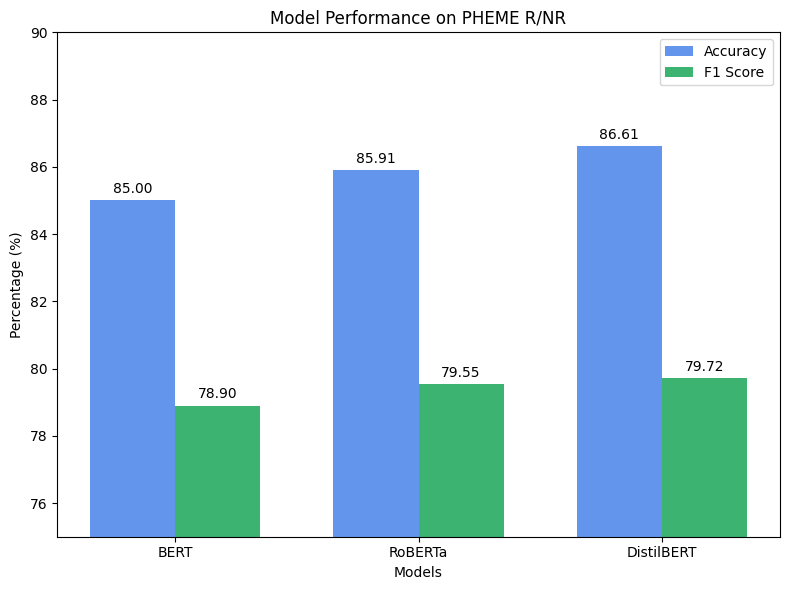

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Model": ["BERT", "RoBERTa", "DistilBERT"],
    "Accuracy": [85.0, 85.91, 86.61],
    "F1 Score": [78.9, 79.55, 79.72]
}

df = pd.DataFrame(data)

# Print as Table
print(df.to_markdown(index=False))

# Plot grouped bar chart
bar_width = 0.35
x = range(len(df))

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar([i - bar_width/2 for i in x], df["Accuracy"], width=bar_width, label="Accuracy", color="cornflowerblue")
bars2 = ax.bar([i + bar_width/2 for i in x], df["F1 Score"], width=bar_width, label="F1 Score", color="mediumseagreen")

# Labels and titles
ax.set_xlabel("Models")
ax.set_ylabel("Percentage (%)")
ax.set_title("Model Performance on PHEME R/NR")
ax.set_xticks(x)
ax.set_xticklabels(df["Model"])
ax.set_ylim(75, 90)
ax.legend()

# Add value labels on top of each bar
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Conclusion

I fine-tuned BERT, RoBERTa, and DistilBERT on the PHEME dataset for misinformation detection. All models performed well, with DistilBERT achieving the best balance of accuracy and speed. The results show that transformer-based models are effective for rumour detection in social media data.